In [102]:
import os
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset

from bc.beats import get_beat_bank
from bc.plot import plot_beat, plot_four_beats

base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the beat types they contain
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'), dtype={'record':object})
beat_table.set_index('record', inplace=True)

In [12]:
# Load beats with fixed width.
n_beats, n_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='N', filter=True, fixed_width=240)
l_beats, l_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='L' ,filter=True, fixed_width=240)
r_beats, r_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='R', filter=True, fixed_width=240)
v_beats, v_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='V', filter=True, fixed_width=240)

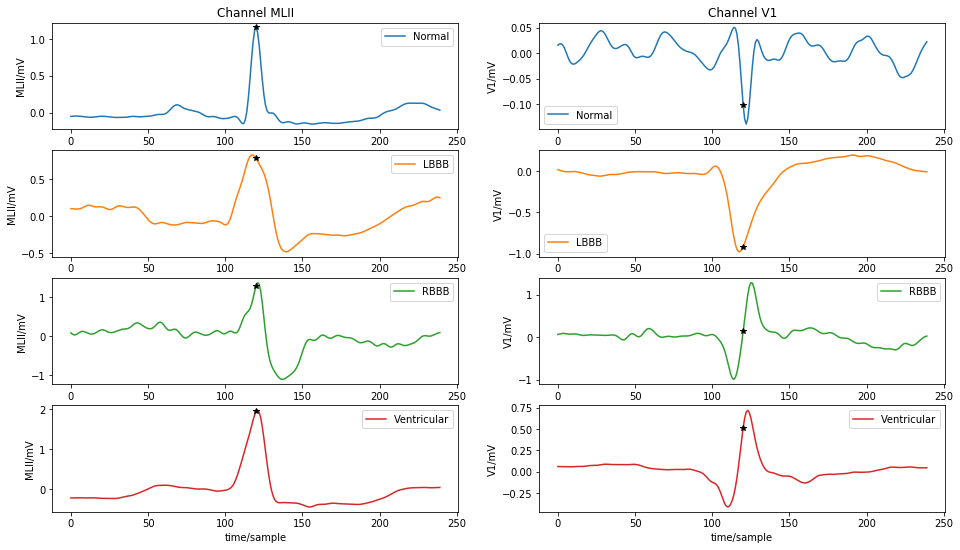

In [13]:
# Now all beats have the same number of samples
plot_four_beats(beats=[n_beats[0], l_beats[0], r_beats[0], v_beats[0]],
                centers=[n_centers[0], l_centers[0], r_centers[0], v_centers[0]],
                seconds=False)

In [37]:
% matplotlib qt

In [66]:
# Visualize how a beat will look as an M x 2 image
# Stretch a beat channelwise just for visualization
stretch_factor = 20
beat_image = np.empty([n_beats[0].shape[1] * stretch_factor, n_beats[0].shape[0]])
for i in range(stretch_factor):
    for ch in range(2):
        beat_image[ch*stretch_factor + i, :] = n_beats[0][:, ch]
plt.figure()
plt.imshow(beat_image, cmap='binary')
plt.show()

In [80]:
# Turn all beats into a large tensor
beats_all = torch.from_numpy(np.array(n_beats + l_beats + r_beats + v_beats))

In [81]:
labels_all = torch.tensor([0]*len(n_beats) + [1]*len(l_beats)
                            + [2]*len(r_beats) + [3]*len(v_beats), dtype=torch.uint8)

In [ ]:
# Define the neural network structure
class BeatNet(nn.Module):
    def __init__(self):
        super(BeatNet, self).__init__()
        # 1 input channel, 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1,3))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(1,3))
        # maxpool function
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # First fully connected layer
        self.fc1 = nn.Linear(8 * 3, 12)
        # Final fully connected layer 
        self.fc2 = nn.Linear(12, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [114]:
# Define a Dataset class to iterate the beats
class BeatDataset(Dataset):
    def __init__(self, beats, labels):
        self.beats = beats
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        x = self.beats[index]
        y = self.labels[index]
        return x, y

In [115]:
# The loader to load our beat data
beatloader = DataLoader(dataset=BeatDataset(beats_all, labels_all),
                        shuffle=True, batch_size=8, num_workers=2)

In [117]:
for i, data in enumerate(beatloader, 0):        
    #Get inputs
    inputs, labels = data
    
    print(i, inputs.shape, labels)
    
    
    if i == 100:
        break

0 torch.Size([8, 240, 2]) tensor([0, 0, 2, 0, 0, 2, 1, 1], dtype=torch.uint8)
1 torch.Size([8, 240, 2]) tensor([3, 0, 0, 2, 3, 2, 0, 0], dtype=torch.uint8)
2 torch.Size([8, 240, 2]) tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
3 torch.Size([8, 240, 2]) tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
4 torch.Size([8, 240, 2]) tensor([3, 2, 0, 1, 3, 0, 0, 0], dtype=torch.uint8)
5 torch.Size([8, 240, 2]) tensor([0, 1, 0, 2, 0, 1, 0, 0], dtype=torch.uint8)
6 torch.Size([8, 240, 2]) tensor([2, 0, 0, 2, 0, 0, 0, 0], dtype=torch.uint8)
7 torch.Size([8, 240, 2]) tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
8 torch.Size([8, 240, 2]) tensor([0, 0, 0, 0, 1, 0, 2, 1], dtype=torch.uint8)
9 torch.Size([8, 240, 2]) tensor([0, 0, 1, 0, 1, 3, 0, 0], dtype=torch.uint8)
10 torch.Size([8, 240, 2]) tensor([0, 0, 2, 0, 0, 0, 3, 0], dtype=torch.uint8)
11 torch.Size([8, 240, 2]) tensor([0, 0, 0, 3, 0, 0, 0, 0], dtype=torch.uint8)
12 torch.Size([8, 240, 2]) tensor([3, 0, 0, 0, 0, 1, 0, 1], dt

In [92]:
help(DataLoader)

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(builtins.object)
 |  Data loader. Combines a dataset and a sampler, and provides
 |  single- or multi-process iterators over the dataset.
 |  
 |  Arguments:
 |      dataset (Dataset): dataset from which to load the data.
 |      batch_size (int, optional): how many samples per batch to load
 |          (default: ``1``).
 |      shuffle (bool, optional): set to ``True`` to have the data reshuffled
 |          at every epoch (default: ``False``).
 |      sampler (Sampler, optional): defines the strategy to draw samples from
 |          the dataset. If specified, ``shuffle`` must be False.
 |      batch_sampler (Sampler, optional): like sampler, but returns a batch of
 |          indices at a time. Mutually exclusive with :attr:`batch_size`,
 |          :attr:`shuffle`, :attr:`sampler`, and :attr:`drop_last`.
 |      num_workers (int, optional): how many subprocesses to use for data
 |          loading. 0 m

In [67]:


def train_net(net, batch_size, n_epochs, learning_rate):
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            # Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

NameError: name 'training_start_time' is not defined

In [ ]:
train_net(net, batch_size, n_epochs, learning_rate):